<a href="https://colab.research.google.com/github/amanzoni1/llm_fine_tuning/blob/main/RL_LLama3_1_8B_GRPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning -  LLama3.1-8B with GRPO & CoT Reasoning

In this notebook we transform LLaMA 3.1-8B into a reasoning-capable text summarization model through a two-phase training approach—trained on a free Colab T4 GPU—that both thinks step-by-step and produces high-quality summaries. We begin with supervised fine-tuning on GSM8K mathematical problems to teach the model our custom reasoning format, ensuring it learns to structure its thinking process before providing answers.

For the second phase, we employ Group Relative Policy Optimization (**GRPO**) on the XSum summarization dataset, using reward functions that evaluate both format compliance and content quality through ROUGE scores, BERTScore semantic similarity, and length penalties. We combine 4-bit quantization  with LoRA adapters to keep VRAM under control, while vLLM provides efficient batch inference during RL training.
**Shoutout to [Unsloth](https://github.com/unslothai/unsloth) for the great performance boost.**

After training, we achieve a model capable of producing structured good quality summaries with explicit reasoning chains—demonstrating how reinforcement learning can align language models with complex, multi-objective reward functions while maintaining computational efficiency on consumer hardware.


In [ ]:
#@title Colab Install & Setup { display-mode: "form" }
%%capture
# Install Unsloth + vLLM (pinned versions)
!pip install --no-deps unsloth vllm==0.8.5.post1

# Core dependencies for LoRA, TRL, and bitsandbytes on Colab
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft "trl==0.15.2" triton cut_cross_entropy unsloth_zoo

# Common NLP libraries
!pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub transformers==4.51.3

# Evaluation‐metric
!pip install evaluate rouge_score bert_score

# vLLM extra requirements (skip numpy/transformers/xformers to avoid conflicts)
import requests, re
reqs = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
filtered = re.sub(rb"(transformers|numpy|xformers)[^\n]*\n", b"", reqs)
with open("vllm_requirements.txt","wb") as f:
    f.write(filtered)
!pip install -r vllm_requirements.txt

In [ ]:
import re, gc, os, getpass
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from unsloth import FastLanguageModel
from datasets import load_dataset, Dataset
from transformers import TextStreamer
from trl import SFTTrainer, SFTConfig, GRPOConfig, GRPOTrainer
from vllm import SamplingParams
from evaluate import load as load_metric

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 06-10 15:10:31 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 06-10 15:10:31 [__init__.py:239] Automatically detected platform cuda.


In [ ]:
# Prompt for the token
hf_token = getpass.getpass('Enter your HF access token and press enter: ')

# Set the environment variable
os.environ['HF_TOKEN'] = hf_token

print("HF_TOKEN environment variable has been set.")

Enter your HF access token and press enter: ··········
HF_TOKEN environment variable has been set.


## Base Model
Load LLaMA 3.1-8B with 4-bit quantization and LoRA adapters for memory efficiency.

In [ ]:
model = "unsloth/Meta-Llama-3.1-8B-bnb-4bit"
hub_model = "AManzoni/llama-grpo-rl"

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name            = model,
    max_seq_length        = 512,
    load_in_4bit          = True,
    fast_inference        = True,
    max_lora_rank         = 16,
)

==((====))==  Unsloth 2025.6.1: Fast Llama patching. Transformers: 4.51.3. vLLM: 0.8.5.post1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/meta-llama-3.1-8b-bnb-4bit with actual GPU utilization = 49.53%
Unsloth: Your GPU has CUDA compute capability 7.5 with VRAM = 14.74 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 512. Num Sequences = 128.
Unsloth: vLLM's KV Cache can use up to 1.2 GB. Also swap space = 0 GB.
WARNING 06-10 11:40:48 [config.py:2972] Casting torch.bfloat16 to torch.float16.
INFO 06-10 11:41:05 [config.py:717] This model supports multiple tasks: {'classify', 'generate', 'score', 'reward', '

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

INFO 06-10 11:41:14 [cuda.py:240] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 06-10 11:41:14 [cuda.py:289] Using XFormers backend.
INFO 06-10 11:41:15 [parallel_state.py:1004] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0
INFO 06-10 11:41:15 [model_runner.py:1108] Starting to load model unsloth/meta-llama-3.1-8b-bnb-4bit...
INFO 06-10 11:41:15 [loader.py:1187] Loading weights with BitsAndBytes quantization. May take a while ...
INFO 06-10 11:41:18 [weight_utils.py:265] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

INFO 06-10 11:42:13 [weight_utils.py:281] Time spent downloading weights for unsloth/meta-llama-3.1-8b-bnb-4bit: 54.822136 seconds
INFO 06-10 11:42:13 [weight_utils.py:315] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 06-10 11:42:44 [punica_selector.py:18] Using PunicaWrapperGPU.
INFO 06-10 11:42:44 [model_runner.py:1140] Model loading took 5.4442 GiB and 88.606556 seconds
INFO 06-10 11:42:55 [worker.py:287] Memory profiling takes 10.43 seconds
INFO 06-10 11:42:55 [worker.py:287] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.50) = 7.30GiB
INFO 06-10 11:42:55 [worker.py:287] model weights take 5.44GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 0.59GiB; the rest of the memory reserved for KV Cache is 1.24GiB.
INFO 06-10 11:42:56 [executor_base.py:112] # cuda blocks: 632, # CPU blocks: 0
INFO 06-10 11:42:56 [executor_base.py:117] Maximum concurrency for 512 tokens per request: 19.75x
INFO 06-10 11:42:56 [model_runner.py:1450] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-

Capturing CUDA graph shapes:   0%|          | 0/19 [00:00<?, ?it/s]

INFO 06-10 11:43:39 [model_runner.py:1592] Graph capturing finished in 44 secs, took 0.47 GiB
INFO 06-10 11:43:39 [llm_engine.py:437] init engine (profile, create kv cache, warmup model) took 55.23 seconds
Unsloth: Just some info: will skip parsing ['k_norm', 'post_feedforward_layernorm', 'pre_feedforward_layernorm', 'q_norm']
Unsloth: Just some info: will skip parsing ['k_norm', 'post_feedforward_layernorm', 'pre_feedforward_layernorm', 'q_norm']


tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    random_state               = 123,
    r                          = 16,
    lora_alpha                 = 32,
    bias                       = "none",
    use_gradient_checkpointing = "unsloth",
    target_modules             = ["q_proj", "k_proj", "v_proj", "o_proj",
                                  "gate_proj", "up_proj", "down_proj"],
)

Unsloth 2025.6.1 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


## Supervised Fine-Tuning (SFT)
We start by teaching the model proper reasoning structure using GSM8K mathematical word problems. Each example is formatted to include explicit reasoning steps enclosed in special tokens, training the model to "think out loud" before providing final answers. This creates a solid foundation for structured output generation.

### Chat Template
Define special reasoning tokens (`<REASONING>`, `<SOLUTION>`) and create a custom chat template.
This teaches the model to structure its thinking process with explicit reasoning steps before providing answers.

In [ ]:
# Define special tokens and system prompt
reasoning_start = "<REASONING>"
reasoning_end   = "</REASONING>"
solution_start  = "<SOLUTION>"
solution_end    = "</SOLUTION>"

system_prompt = (
    "You are given a problem.\n"
    "Think over it and describe your step‐by‐step reasoning.\n"
    f"Enclose reasoning between {reasoning_start} and {reasoning_end}.\n"
    f"Finally, give your answer between {solution_start} and {solution_end}"
)

In [ ]:
# Build and assign chat_template to the tokenizer

chat_template = (
    # If the very first message is a SYSTEM role, print it + <eos>:
    "{% if messages[0]['role'] == 'system' %}"
      "{{ messages[0]['content'] + eos_token }}"
      "{% set rest = messages[1:] %}"
    "{% else %}"
      # Otherwise, inject our system_prompt + <eos>:
      "{{ '{system_prompt}' + eos_token }}"
      "{% set rest = messages %}"
    "{% endif %}"

    # Now loop over the remaining messages (either user or assistant):
    "{% for m in rest %}"
      "{% if m['role'] == 'user' %}"
        "{{ m['content'] }}"
      "{% else %}"  # assistant
        "{{ m['content'] + eos_token }}"
      "{% endif %}"
    "{% endfor %}"

    # If we asked for “add_generation_prompt,” append <REASONING> to the end:
    "{% if add_generation_prompt %}"
      "{{ '{reasoning_start}' }}"
    "{% endif %}"
)

chat_template = chat_template\
    .replace("'{system_prompt}'",   f"'{system_prompt}'")\
    .replace("'{reasoning_start}'", f"'{reasoning_start}'")

In [ ]:
tokenizer.chat_template = chat_template

In [ ]:
# Quick sanity check of the template
example_messages = [
    {"role": "user",
     "content": "Which country has the highest population density?"},
    {"role": "assistant",
     "content": (
         f"{reasoning_start}"
         "I know that country X is small in area but has a huge population, "
         "so its people per square kilometer is extremely high."
         f"{reasoning_end}"
         f"{solution_start}Monaco{solution_end}"
     )},
    {"role": "user",
     "content": "Which planet is farthest from the Sun?"},
]


print("Rendered example:\n")
print(tokenizer.apply_chat_template(example_messages, tokenize=False, add_generation_prompt = True))

Rendered example:

You are given a problem.
Think over it and describe your step‐by‐step reasoning.
Enclose reasoning between <REASONING> and </REASONING>.
Finally, give your answer between <SOLUTION> and </SOLUTION><|end_of_text|>Which country has the highest population density?<REASONING>I know that country X is small in area but has a huge population, so its people per square kilometer is extremely high.</REASONING><SOLUTION>Monaco</SOLUTION><|end_of_text|>Which planet is farthest from the Sun?<REASONING>


### Dataset
Load GSM8K math problems and format them with our reasoning structure.
Transform mathematical word problems into training examples that demonstrate step-by-step thinking patterns.

In [ ]:
# Load the dataset
dataset = load_dataset("openai/gsm8k", "main", split="train")
dataset

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Dataset({
    features: ['question', 'answer'],
    num_rows: 7473
})

In [ ]:
print("=== Raw GSM8K columns ===")
print(dataset.column_names)
print("\n=== First raw example ===")
print(dataset[0])

=== Raw GSM8K columns ===
['question', 'answer']

=== First raw example ===
{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?', 'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72'}


In [ ]:
# Define formatting + token-count function
def format_and_count_gsm8k(example):
    question = example["question"].strip()
    reasoning = example["answer"].split("####")[0].replace("\n", " ").strip()
    final_ans = example["answer"].split("####")[1].strip()

    messages = [
        {"role": "system",    "content": system_prompt},
        {"role": "user",      "content": question},
        {"role": "assistant", "content": (
            f"{reasoning_start}{reasoning}{reasoning_end}"
            f"{solution_start}{final_ans}{solution_end}"
        )}
    ]

    enc = tokenizer.apply_chat_template(messages, tokenize=True)
    if isinstance(enc, dict):
        token_len = len(enc["input_ids"])
    else:
        token_len = len(enc)

    text_str = tokenizer.apply_chat_template(messages, tokenize=False)

    return {
        "token_len": token_len,
        "text": text_str,
        "Messages": messages
    }

In [ ]:
# Apply formatting to the dataset
dataset = dataset.map(
    format_and_count_gsm8k,
    remove_columns=dataset.column_names,
)

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

In [ ]:
# Sanity check: print a few "text" examples before filtering
print("\n=== Few formatted text examples (first 3) ===")
for i in range(3):
    print(f"\n--- Example {i} ---")
    print(dataset[i]["text"])


=== Few formatted text examples (first 3) ===

--- Example 0 ---
You are given a problem.
Think over it and describe your step‐by‐step reasoning.
Enclose reasoning between <REASONING> and </REASONING>.
Finally, give your answer between <SOLUTION> and </SOLUTION><|end_of_text|>Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?<REASONING>Natalia sold 48/2 = <<48/2=24>>24 clips in May. Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.</REASONING><SOLUTION>72</SOLUTION><|end_of_text|>

--- Example 1 ---
You are given a problem.
Think over it and describe your step‐by‐step reasoning.
Enclose reasoning between <REASONING> and </REASONING>.
Finally, give your answer between <SOLUTION> and </SOLUTION><|end_of_text|>Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?<REASONING>Weng earns 12/60 = $<<12/60=0.2>

In [ ]:
# Token-length statistics and dataset filtered for training
lengths = np.array(dataset["token_len"])
print("\nToken-length percentiles (50/90/99):", np.percentile(lengths, [50, 90, 99]))

threshold = 200
sft_ds_filtered     = dataset.filter(lambda ex: ex["token_len"] <= threshold)
sft_ds_filtered     = sft_ds_filtered.select(range(100))
sft_ds_filtered_out = dataset.filter(lambda ex: ex["token_len"] >  threshold)

print(f"\nRemaining for training (≤{threshold} tokens): {len(sft_ds_filtered)} / {len(dataset)}")


Token-length percentiles (50/90/99): [210. 299. 390.]


Filter:   0%|          | 0/7473 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7473 [00:00<?, ? examples/s]


Remaining for training (≤200 tokens): 100 / 7473


In [ ]:
# Drop extra columns so dataset contains only "text"
sft_dataset = sft_ds_filtered.remove_columns(["token_len", "Messages"])
print("\n=== Final dataset ===")
print(sft_dataset)


=== Final dataset ===
Dataset({
    features: ['text'],
    num_rows: 100
})


### Training

In [ ]:
# Define training arguments
sft_config = SFTConfig(
    seed                        = 123,
    do_train                    = True,
    num_train_epochs            = 2,
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 2,
    learning_rate               = 2e-4,
    lr_scheduler_type           = "linear",
    warmup_ratio                = 0.03,
    weight_decay                = 0.01,
    logging_strategy            = "steps",
    logging_steps               = 5,
    report_to                   = "none",
)

In [ ]:
# Instantiate SFTTrainer
trainer = SFTTrainer(
    model         = model,
    args          = sft_config,
    train_dataset = sft_dataset,
    tokenizer     = tokenizer,
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100 | Num Epochs = 2 | Total steps = 50
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
5,1.669500
10,0.886700
15,0.767000
20,0.691600
25,0.766400
30,0.628400
35,0.576400
40,0.565500
45,0.572400
50,0.511300


TrainOutput(global_step=50, training_loss=0.7635331630706788, metrics={'train_runtime': 141.125, 'train_samples_per_second': 1.417, 'train_steps_per_second': 0.354, 'total_flos': 893591679762432.0, 'train_loss': 0.7635331630706788})

### Check output

In [ ]:
# Pick one example’s first two “system + user” messages
prompt_messages = sft_ds_filtered_out[0]["Messages"][:2]

# Render into a single string and append <REASONING> for generation:
text = tokenizer.apply_chat_template(
    prompt_messages,
    tokenize=False,
    add_generation_prompt=True,  # append the final <REASONING>
)

In [ ]:
# Stream the model’s generations (CoT + solution)
streamer = TextStreamer(tokenizer, skip_prompt=False)

_ = model.generate(
    **tokenizer(text, return_tensors="pt").to("cuda"),
    temperature    = 0.0,
    max_new_tokens = 512,
    streamer       = streamer,
)

<|begin_of_text|>You are given a problem.
Think over it and describe your step‐by‐step reasoning.
Enclose reasoning between <REASONING> and </REASONING>.
Finally, give your answer between <SOLUTION> and </SOLUTION><|end_of_text|>Julie is reading a 120-page book. Yesterday, she was able to read 12 pages and today, she read twice as many pages as yesterday. If she wants to read half of the remaining pages tomorrow, how many pages should she read?<REASONING>Yesterday, Julie read 12*2=<<12*2=24>>24 pages. So, she has 120-24=<<120-24=96>>96 pages left. Half of 96 is 96/2=<<96/2=48>>48 pages. So, Julie should read 48-24=<<48-24=24>>24 pages tomorrow.</REASONING><SOLUTION>24</SOLUTION><|end_of_text|>


In [ ]:
del dataset, sft_ds_filtered, sft_ds_filtered_out, sft_dataset

# Free up Python objects and empty GPU cache
gc.collect()
torch.cuda.empty_cache()

## GRPO Reinforcement Learning (RL)
Using the XSum news summarization dataset, we employ Group Relative Policy Optimization with dual reward functions: a format compliance reward (ensuring proper use of reasoning/solution tags) and a content quality reward (combining ROUGE-2 F1, BERTScore semantic similarity, and length penalties). This phase optimizes the model's ability to generate high-quality summaries while maintaining the reasoning structure learned in Phase 1.

### Dataset
Load and prepare XSum news articles for summarization training.
Filter documents by length and format them as prompts for reinforcement learning optimization.

In [ ]:
# Load the full XSum train split into memory
dataset = load_dataset("EdinburghNLP/xsum", split="train")
dataset

README.md:   0%|          | 0.00/6.24k [00:00<?, ?B/s]

xsum.py:   0%|          | 0.00/5.76k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/304M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/16.7M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 204045
})

In [ ]:
# Keep only the first 200 documents whose raw token count ≤ 300
DOC_CUTOFF = 300
TARGET_EXAMPLES = 200

selected = []
for ex in dataset:
    # ex["document"] is the source text, ex["summary"] is the gold summary.
    doc_tokens = tokenizer(
        ex["document"],
        truncation=False,  # we just want to measure length, not truncate
    )["input_ids"]
    if len(doc_tokens) <= DOC_CUTOFF:
        selected.append({
            "document": ex["document"],
            "summary":  ex["summary"]
        })
        if len(selected) >= TARGET_EXAMPLES:
            break

print(f"✔ Collected {len(selected)} examples with doc‐tokens ≤ {DOC_CUTOFF}.")

✔ Collected 200 examples with doc‐tokens ≤ 300.


In [ ]:
# Build a Hugging Face Dataset from that Python list
dataset = Dataset.from_list(selected)
dataset

Dataset({
    features: ['document', 'summary'],
    num_rows: 200
})

In [ ]:
# Adjust the prompt
system_prompt = (
    "You are given a text.\n"
    "Think carefully about its main points and organize your reasoning.\n"
    f"Enclose reasoning between {reasoning_start} and {reasoning_end}.\n"
    f"Finally, provide the final summary between {solution_start} and {solution_end}"
)

In [ ]:
# Turn each document into a formatted “text” string
def to_grpo_input(ex):
    # Build the `<SYSTEM> + <USER>` prompt, then append "<REASONING>" so model knows to start thinking.
    messages = [
        {"role": "system",  "content": system_prompt},
        {"role": "user",    "content": ex["document"]}
    ]
    text_str = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True  # this injects "<REASONING>" at the end
    )
    full_ids = tokenizer(text_str, truncation=False)["input_ids"]

    return {
        "prompt": text_str,
        "gold_summary": ex["summary"],
        "full_len": len(full_ids)
    }

dataset = dataset.map(to_grpo_input)


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
# Check token‐length percentiles on the newly‐built “text” field
full_lens = np.array(dataset["full_len"])

print("✔ Final “prompt” lengths 50/90/99 pct:", np.percentile(full_lens, [50,90,99]))

✔ Final “prompt” lengths 50/90/99 pct: [232. 331. 353.]


In [ ]:
# Remove every column except the needed columns
rl_dataset = dataset.remove_columns([c for c in dataset.column_names
                                    if c not in ("prompt","gold_summary")])

rl_dataset

Dataset({
    features: ['prompt', 'gold_summary'],
    num_rows: 200
})

In [ ]:
# Sanity check
print("✔ Ready for GRPO")

print("columns now:", rl_dataset.column_names)

for i in range(3):
    print(f"\n─ Example {i} ─")
    print("text :", repr(rl_dataset[i]["prompt"]))
    print("gold :", repr(rl_dataset[i]["gold_summary"]))

✔ Ready for GRPO
columns now: ['prompt', 'gold_summary']

─ Example 0 ─
text : 'You are given a text.\nThink carefully about its main points and organize your reasoning.\nEnclose reasoning between <REASONING> and </REASONING>.\nFinally, provide the final summary between <SOLUTION> and </SOLUTION><|end_of_text|>A fire alarm went off at the Holiday Inn in Hope Street at about 04:20 BST on Saturday and guests were asked to leave the hotel.\nAs they gathered outside they saw the two buses, parked side-by-side in the car park, engulfed by flames.\nOne of the tour groups is from Germany, the other from China and Taiwan. It was their first night in Northern Ireland.\nThe driver of one of the buses said many of the passengers had left personal belongings on board and these had been destroyed.\nBoth groups have organised replacement coaches and will begin their tour of the north coast later than they had planned.\nPolice have appealed for information about the attack.\nInsp David Gibson said: "

### Reward funtions
Create dual reward system: format compliance (proper tag usage) + content quality (ROUGE/BERTScore).
These functions guide the RL training to produce both well-structured and high-quality summaries.

In [ ]:
# Build an “</SOLUTION> + optional EOS/whitespace” pattern
solution_end_regex = (
    r"</SOLUTION>"
  + r"[\s]*"
  + "(?:" + re.escape(tokenizer.eos_token) + ")?"
)

# Build a single regex that matches “</REASONING> … <SOLUTION> … </SOLUTION>” at the end
match_full_format = re.compile(
    rf"{reasoning_end}"        # literally "</REASONING>"
    r".*?"                     # any characters (DOTALL)
    rf"{solution_start}"       # literally "<SOLUTION>"
    r"(.+?)"                   # (capture group for content, but we don’t use it here)
    rf"{solution_end_regex}"   # the literal "</SOLUTION>" + optional whitespace + optional EOS
    r"[\s]*$"                  # anchored at the end of the string
,   flags = re.MULTILINE | re.DOTALL
)

In [ ]:
# Reward func for the format
def reward_format(completions, **kwargs):
    """
    Returns one float per generated completion:
      • +3.0  if there is exactly one </REASONING>,
               exactly one <SOLUTION>, exactly one </SOLUTION>,
               AND that entire sequence “</REASONING>…<SOLUTION>…</SOLUTION>”
               sits at the very end of the string.
      • Otherwise:
          +0.5 if exactly one </REASONING>,     else −0.5
          +0.5 if exactly one <SOLUTION>,       else −0.5
          +0.5 if exactly one </SOLUTION>,      else −0.5
        (so partial tag matches range from −1.5 … +1.5)
      • If none of the three tags appear (all counts == 0), override to −3.0.
    """
    scores = []
    for c in completions:
        if isinstance(c, list) and isinstance(c[0], dict) and "content" in c[0]:
            resp = c[0]["content"]
        elif isinstance(c, dict) and "content" in c:
            resp = c["content"]
        else:
            resp = str(c)

        # Count how many times each tag appears
        cnt_rend  = resp.count(reasoning_end)
        cnt_sst   = resp.count(solution_start)
        cnt_send  = resp.count(solution_end)

        # Case A: “Perfect” only if exactly one of each tag *and* the regex matches at the very end
        if (cnt_rend == 1) and (cnt_sst == 1) and (cnt_send == 1):
            # Now verify the strict end‐of‐string match
            if match_full_format.search(resp):
                scores.append(3.0)
                continue

        # If none of the three tags appear → heavy penalty
        if (cnt_rend == 0) and (cnt_sst == 0) and (cnt_send == 0):
            scores.append(-3.0)
            continue

        # Otherwise, award partial credit/penalty per tag:
        score = 0.0
        score +=  0.5 if (cnt_rend  == 1) else -0.5
        score +=  0.5 if (cnt_sst   == 1) else -0.5
        score +=  0.5 if (cnt_send  == 1) else -0.5
        scores.append(score)

    return scores

In [ ]:
rouge = load_metric("rouge")
bertscore = load_metric("bertscore")

In [ ]:
# Capture everything between <SOLUTION> and </SOLUTION>
solution_regex = re.compile(
    rf"{re.escape(solution_start)}(.*?){re.escape(solution_end)}",
    flags = re.DOTALL | re.MULTILINE
)

In [ ]:
# Extract text from completion
def extract_solution_text(raw: str) -> str:
    m = solution_regex.search(raw)
    if m:
        return m.group(1).strip() or raw.strip()
    return raw.strip()

In [ ]:
# Define a soft length‐reward function
def length_reward(generated: str, reference: str) -> float:
    len_gen = len(generated.split())
    len_ref = len(reference.split())
    dev = abs(len_gen - len_ref) / max(1, len_ref)
    return max(0.0, 1.0 - dev)

In [ ]:
# Build the reward_content function
LEX_WEIGHT    = 3.0
SEM_WEIGHT    = 6.0
LENGTH_WEIGHT = 1.0

def reward_content(prompts, completions, gold_summary, **kwargs):
    """
    Compute a combined content reward for each generated completion:
      1. Extract `gen_summary` between <SOLUTION>…</SOLUTION>, or use full text otherwise.
      2. Compute:
         - rouge2_f1      = ROUGE‐2 F1 score(gen_summary, reference)
         - bert_f1        = BERTScore F1 score(gen_summary, reference)
         - length_penalty = length_reward(gen_summary, reference) in [0,1]
      3. Scale and sum:
         final_score = (rouge2_f1 * LEX_WEIGHT)
                     + (bert_f1  * SEM_WEIGHT)
                     + (length_penalty * LENGTH_WEIGHT)
      => final_score lies in [0, LEX_WEIGHT + SEM_WEIGHT + LENGTH_WEIGHT].
    """
    scores = []
    for completion, reference in zip(completions, gold_summary):
        if isinstance(completion, list) and isinstance(completion[0], dict) and "content" in completion[0]:
            raw = completion[0]["content"]
        elif isinstance(completion, dict) and "content" in completion:
            raw = completion["content"]
        else:
            raw = str(completion)
        gen_summary = extract_solution_text(raw)

        # ROUGE-2 F1 (lexical overlap)
        r = rouge.compute(
            predictions = [gen_summary],
            references  = [reference],
            rouge_types = ["rouge2"],
            use_stemmer = True
        )
        rouge2_f1 = r["rouge2"]

        # BERTScore F1 (semantic similarity)
        b = bertscore.compute(
            predictions = [gen_summary],
            references  = [reference],
            model_type  = "sentence-transformers/all-MiniLM-L6-v2",
            num_layers  = 6
        )
        bert_f1 = b["f1"][0]

        # Length penalty
        lp = length_reward(gen_summary, reference)

        # Scale & sum
        final_score = (rouge2_f1 * LEX_WEIGHT) + (bert_f1 * SEM_WEIGHT) + (lp * LENGTH_WEIGHT)
        scores.append(final_score)

    return scores

### Training
Apply Group Relative Policy Optimization using vLLM for efficient batch inference.
This phase optimizes the model to generate summaries that maximize both format and content rewards.

In [ ]:
vllm_sampling_params = SamplingParams(
    seed                       = 123,
    temperature                = 1.0,
    min_p                      = 0.1,
    top_p                      = 0.95,
    top_k                      = 64,
    stop                       = [tokenizer.eos_token],
    include_stop_str_in_output = True,
)

In [ ]:
grpo_config = GRPOConfig(
    seed                        = 123,
    use_vllm                    = True,
    vllm_sampling_params        = vllm_sampling_params,
    do_train                    = True,
    num_train_epochs            = 2.0,
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 1,
    learning_rate               = 2e-5,
    lr_scheduler_type           = "linear",
    warmup_ratio                = 0.05,
    weight_decay                = 0.01,
    optim                       = "adamw_8bit",
    num_generations             = 4,
    max_completion_length       = 150,
    logging_strategy            = "steps",
    logging_steps               = 20,
    report_to                   = "none",
    output_dir                  = "grpo_outputs",
    overwrite_output_dir        = True,
    save_strategy               = "epoch",
    push_to_hub                 = True,
    hub_model_id                = hub_model,
)

In [ ]:
trainer = GRPOTrainer(
    model            = model,
    processing_class = tokenizer,
    train_dataset    = rl_dataset,
    args             = grpo_config,
    reward_funcs     = [reward_format,
                        reward_content],
)

In [ ]:
# Memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)

print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
7.861 GB of memory reserved.


In [ ]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 200 | Num Epochs = 2 | Total steps = 400
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 1 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss,reward,reward_std,completion_length,kl,rewards / reward_format,rewards / reward_content
20,0.006000,4.016883,1.985057,111.412500,0.149602,1.650000,2.366883
40,0.005200,5.127591,1.696029,94.687500,0.129206,2.193750,2.933841
60,0.003800,5.021083,1.660556,99.600000,0.095368,2.031250,2.989833
80,0.004800,5.726562,1.197577,88.637500,0.121205,2.600000,3.126562
100,0.005100,6.225821,1.073269,90.187500,0.127155,2.718750,3.507071
120,0.007000,6.323594,1.126978,83.487500,0.174052,2.575000,3.748594
140,0.006700,6.627551,1.020549,86.275000,0.168003,2.712500,3.915051
160,0.007700,6.882721,0.864506,67.087500,0.192741,2.875000,4.007722
180,0.007600,6.578654,1.074740,73.262500,0.189216,2.831250,3.747404
200,0.010500,6.903162,0.718387,75.862500,0.262647,2.893750,4.009412


TrainOutput(global_step=400, training_loss=0.008630266636610031, metrics={'train_runtime': 9436.0856, 'train_samples_per_second': 0.042, 'train_steps_per_second': 0.042, 'total_flos': 0.0, 'train_loss': 0.008630266636610031})

In [ ]:
# Final memory and time stats
last_log = trainer.state.log_history[-1]

# Extract runtime info
train_seconds      = last_log["train_runtime"]
samples_per_second = last_log.get("train_samples_per_second", None)

# Recompute GPU memory stats
used_memory     = round(torch.cuda.max_memory_reserved() / 1024**3, 2)
used_for_lora   = round(used_memory - start_gpu_memory, 2)
used_pct        = round(used_memory / max_memory * 100, 2)
lora_pct        = round(used_for_lora / max_memory * 100, 2)

# Print summary
print(f"Training time      : {train_seconds:.1f} seconds ({train_seconds/60:.2f} minutes)")
if samples_per_second:
    print(f"Throughput         : {samples_per_second:.1f} samples/second")
print(f"Peak VRAM usage    : {used_memory} GB ({used_pct}% of max memory)")
print(f"VRAM for training  : {used_for_lora} GB ({lora_pct}% of max memory)")

Training time      : 9436.1 seconds (157.27 minutes)
Throughput         : 0.0 samples/second
Peak VRAM usage    : 8.71 GB (59.09% of max memory)
VRAM for training  : 0.85 GB (5.77% of max memory)


### Visualize GRPO Training Metrics
Below we plot the key training statistics—policy loss, total reward, and KL penalty—to confirm that the model is learning effectively and remaining stable

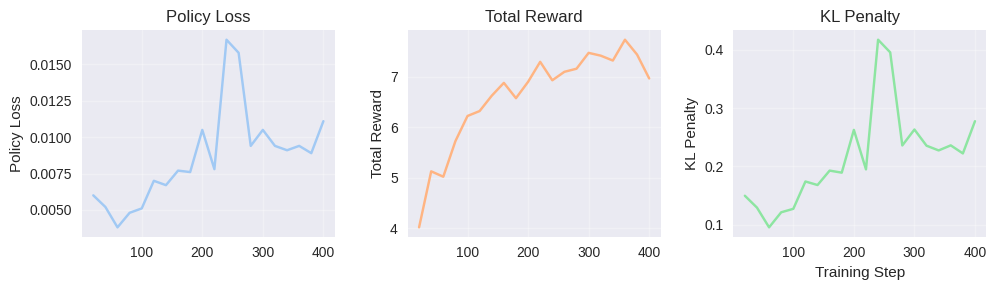

In [ ]:
# Visualize
plt.style.use('seaborn-v0_8')
sns.set_palette("pastel")

logs = trainer.state.log_history

steps      = []
losses     = []
rewards    = []
kl_penalty = []

for log in logs:
    if "loss" in log:
        steps.append(log["step"])
        losses.append(log["loss"])
        rewards.append(log.get("reward", None))
        kl_penalty.append(log.get("kl", None))

plt.figure(figsize=(10, 3))

# Loss vs. Step
plt.subplot(1, 3, 1)
plt.plot(steps, losses, marker="x", linestyle="-", color="C0")
plt.ylabel("Policy Loss")
plt.grid(True, alpha=0.3)
plt.title("Policy Loss")

# Reward vs. Step
plt.subplot(1, 3, 2)
plt.plot(steps, rewards, marker="x", linestyle="-", color="C1")
plt.ylabel("Total Reward")
plt.grid(True, alpha=0.3)
plt.title("Total Reward")

# KL Penalty vs. Step
plt.subplot(1, 3, 3)
plt.plot(steps, kl_penalty, marker="x", linestyle="-", color="C2")
plt.xlabel("Training Step")
plt.ylabel("KL Penalty")
plt.grid(True, alpha=0.3)
plt.title("KL Penalty")

plt.tight_layout()
plt.show()

### Inferences
We gonna reload the saved trained model from the hub, and test it on validation examples to demonstrate capabilities.
We gonna see how the model now produces structured summaries with explicit reasoning chains.

In [ ]:
# Load the trained model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name     = hub_model,
    max_seq_length = 512,
    load_in_4bit   = True,
    fast_inference = True,
    max_lora_rank  = 16,
)

==((====))==  Unsloth 2025.6.2: Fast Llama patching. Transformers: 4.51.3. vLLM: 0.8.5.post1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/meta-llama-3.1-8b-bnb-4bit with actual GPU utilization = 49.53%
Unsloth: Your GPU has CUDA compute capability 7.5 with VRAM = 14.74 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 512. Num Sequences = 128.
Unsloth: vLLM's KV Cache can use up to 1.2 GB. Also swap space = 0 GB.
WARNING 06-10 15:11:39 [config.py:2972] Casting torch.bfloat16 to torch.float16.
INFO 06-10 15:11:56 [config.py:717] This model supports multiple tasks: {'generate', 'classify', 'score', 'embed', 'r

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

INFO 06-10 15:12:04 [cuda.py:240] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 06-10 15:12:04 [cuda.py:289] Using XFormers backend.
INFO 06-10 15:12:05 [parallel_state.py:1004] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0
INFO 06-10 15:12:05 [model_runner.py:1108] Starting to load model unsloth/meta-llama-3.1-8b-bnb-4bit...
INFO 06-10 15:12:05 [loader.py:1187] Loading weights with BitsAndBytes quantization. May take a while ...
INFO 06-10 15:12:07 [weight_utils.py:265] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

INFO 06-10 15:13:10 [weight_utils.py:281] Time spent downloading weights for unsloth/meta-llama-3.1-8b-bnb-4bit: 62.872564 seconds
INFO 06-10 15:13:11 [weight_utils.py:315] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 06-10 15:13:58 [punica_selector.py:18] Using PunicaWrapperGPU.
INFO 06-10 15:14:00 [model_runner.py:1140] Model loading took 5.4442 GiB and 113.590067 seconds
INFO 06-10 15:14:21 [worker.py:287] Memory profiling takes 18.94 seconds
INFO 06-10 15:14:21 [worker.py:287] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.50) = 7.30GiB
INFO 06-10 15:14:21 [worker.py:287] model weights take 5.44GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 0.59GiB; the rest of the memory reserved for KV Cache is 1.24GiB.
INFO 06-10 15:14:21 [executor_base.py:112] # cuda blocks: 632, # CPU blocks: 0
INFO 06-10 15:14:21 [executor_base.py:117] Maximum concurrency for 512 tokens per request: 19.75x
INFO 06-10 15:14:21 [model_runner.py:1450] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out

Capturing CUDA graph shapes:   0%|          | 0/19 [00:00<?, ?it/s]

INFO 06-10 15:15:18 [model_runner.py:1592] Graph capturing finished in 57 secs, took 0.47 GiB
INFO 06-10 15:15:18 [llm_engine.py:437] init engine (profile, create kv cache, warmup model) took 77.96 seconds
Unsloth: Just some info: will skip parsing ['q_norm', 'pre_feedforward_layernorm', 'k_norm', 'post_feedforward_layernorm']
Unsloth: Just some info: will skip parsing ['q_norm', 'pre_feedforward_layernorm', 'k_norm', 'post_feedforward_layernorm']


tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Unsloth 2025.6.2 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
# Set up again the chat template
reasoning_start = "<REASONING>"
reasoning_end   = "</REASONING>"
solution_start  = "<SOLUTION>"
solution_end    = "</SOLUTION>"

system_prompt = (
    "You are given a text.\n"
    "Think carefully about its main points and organize your reasoning.\n"
    f"Enclose reasoning between {reasoning_start} and {reasoning_end}.\n"
    f"Finally, provide the final summary between {solution_start} and {solution_end}"
)

chat_template = (
    "{% if messages[0]['role'] == 'system' %}"
      "{{ messages[0]['content'] + eos_token }}"
      "{% set rest = messages[1:] %}"
    "{% else %}"
      "{{ '{system_prompt}' + eos_token }}"
      "{% set rest = messages %}"
    "{% endif %}"
    "{% for m in rest %}"
      "{% if m['role'] == 'user' %}"
        "{{ m['content'] }}"
      "{% else %}"
        "{{ m['content'] + eos_token }}"
      "{% endif %}"
    "{% endfor %}"
    "{% if add_generation_prompt %}"
      "{{ '{reasoning_start}' }}"
    "{% endif %}"
)

chat_template = chat_template\
    .replace("'{system_prompt}'",   f"'{system_prompt}'")\
    .replace("'{reasoning_start}'", f"'{reasoning_start}'")

In [ ]:
tokenizer.chat_template = chat_template

In [ ]:
# Load validation dataset
val_ds   = load_dataset("EdinburghNLP/xsum", split="validation")
examples = val_ds.select(range(3))

README.md:   0%|          | 0.00/6.24k [00:00<?, ?B/s]

xsum.py:   0%|          | 0.00/5.76k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/304M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/16.7M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

In [ ]:
# Print out some example with the trained model
for i, ex in enumerate(examples):
    print(f"\n=== Example {i} ===")
    print("SOURCE DOCUMENT:")
    print(ex["document"][:400].strip(), "…\n")
    print("REFERENCE SUMMARY:")
    print(ex["summary"], "\n")
    print("MODEL SUMMARY:")

    # Build prompt
    prompt = [
        {"role":"system","content":system_prompt},
        {"role":"user",  "content":ex["document"].strip()},
    ]
    text = tokenizer.apply_chat_template(
        prompt,
        tokenize=False,
        add_generation_prompt=True,
    )

    streamer = TextStreamer(tokenizer, skip_prompt=False)
    _ = model.generate(
        **tokenizer(text, return_tensors="pt").to("cuda"),
        temperature    = 1.0,
        max_new_tokens = 150,
        streamer       = streamer,
    )
    print("\n" + "="*60)


=== Example 0 ===
SOURCE DOCUMENT:
The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian sport.
Mr Sodje, 37, is jointly charged with elder brothers Efe, 44, Bright, 50 and Stephen, 42.
Appearing at the Old Bailey earlier, all four denied the offence.
The charge relates to offences which allegedly took place between 2008 and 2014.
Sam, from Kent, Ef …

REFERENCE SUMMARY:
Former Premier League footballer Sam Sodje has appeared in court alongside three brothers accused of charity fraud. 

MODEL SUMMARY:
<|begin_of_text|>You are given a text.
Think carefully about its main points and organize your reasoning.
Enclose reasoning between <REASONING> and </REASONING>.
Finally, provide the final summary between <SOLUTION> and </SOLUTION><|end_of_text|>The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian sport.
Mr Sodje, 37, is 

### GGUF / llama.cpp Conversion
Unsloth support saving to `GGUF` / `llama.cpp` in multiple quantization formats.

In [ ]:
# Save to q4_k_m GGUF
# model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
# model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m")

# Save & push different GGUF quant formats in one call:
model.push_to_hub_gguf(
    "AManzoni/llama3.1_8b_GRPO",
    tokenizer,
    quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
    # token = "", #If not logged in the colab
)